In [1]:
import ete3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from evcouplings.align import Alignment
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Step 1: verify input data meets quality controls

In [2]:
mutation_matrix = np.load("00.mutation_data_by_lineage/00.combined_data/all_mutation_matrix_5strain_filtering.npy")
reversion_matrix = np.load("00.mutation_data_by_lineage/00.combined_data/all_reversion_matrix_5strain_filtering.npy")
n_mutations_per_position = mutation_matrix.sum(axis=0) + reversion_matrix.sum(axis=0)
print("We find this many positions with no mutation", len(np.argwhere(n_mutations_per_position==0)))

We find this many positions with no mutation 0


## Step 2: Impose filtering for number of mutation events

In [6]:
# Load list of all positions
positions = np.load("00.mutation_data_by_lineage/00.combined_data/all_positions_5strain_filtering.npy")
mutation_frequency_table = pd.read_csv("00.mutation_data_by_lineage/event_frequency_table.csv")

#Makes sure that the 5 events we observed are actually mutations - not reversions
mutation_frequency_table_filtered = mutation_frequency_table.query("Position in @positions")
mutation_frequency_table_filtered["mutations_from_mutmat"] = mutation_matrix.sum(axis=0)

N=5
at_least_5_mutations = mutation_frequency_table_filtered.query(f"mutations_from_mutmat >= {N}")
print(f"{len(at_least_5_mutations)} positions have {N} or more mutations ")

# Get the indices of positions that meet the quality filter
f_hits = set(at_least_5_mutations.Position)
filtered_positions = [x for x in positions if x in f_hits]
pos_list = list(positions)
filtered_position_idx = [pos_list.index(x) for x in filtered_positions]


4776 positions have 5 or more mutations 


In [8]:
# Filter the mutation, background, and reversion matrix
!mkdir 01.mutation_and_comutation_data

mutation_matrix = np.load("00.mutation_data_by_lineage/00.combined_data/all_mutation_matrix_5strain_filtering.npy")
background_matrix = np.load("00.mutation_data_by_lineage/00.combined_data/all_background_matrix_5strain_filtering.npy")
reversion_matrix = np.load("00.mutation_data_by_lineage/00.combined_data/all_reversion_matrix_5strain_filtering.npy")

filtered_mutation_matrix = mutation_matrix[:,np.array(filtered_position_idx)]
filtered_background_matrix = background_matrix[:,np.array(filtered_position_idx)]
filtered_reversion_matrix = reversion_matrix[:,np.array(filtered_position_idx)]

np.save("01.mutation_and_comutation_data/all_mutation_matrix_5event_filtering.npy", filtered_mutation_matrix)
np.save("01.mutation_and_comutation_data/all_reversion_matrix_5event_filtering.npy", filtered_reversion_matrix)
np.save("01.mutation_and_comutation_data/all_background_matrix_5event_filtering.npy", filtered_background_matrix)
np.save("01.mutation_and_comutation_data/all_positions_5event_filtering.npy", np.array(filtered_positions))

mkdir: cannot create directory ‘01.mutation_and_comutation_data’: File exists


## Step 3: generate first-order statistics df

In [9]:
mutation_matrix = np.load("01.mutation_and_comutation_data/all_mutation_matrix_5event_filtering.npy")
background_matrix = np.load("01.mutation_and_comutation_data/all_background_matrix_5event_filtering.npy")
reversion_matrix = np.load("01.mutation_and_comutation_data/all_reversion_matrix_5event_filtering.npy")
positions = np.load("01.mutation_and_comutation_data/all_positions_5event_filtering.npy")
print(positions.shape, mutation_matrix.shape, background_matrix.shape, reversion_matrix.shape)

mutations_sum = np.sum(mutation_matrix, axis=0)
reversions_sum = np.sum(reversion_matrix, axis=0)
background_sum = np.sum(background_matrix, axis=0)

first_order_stats = pd.DataFrame({
    "pos": positions, 
    "n_mutations": mutations_sum, 
    "n_reversions": reversions_sum, 
    "n_branches_with": background_sum
})
first_order_stats["mat_index"] = first_order_stats.index  
first_order_stats.to_csv("01.mutation_and_comutation_data/first_order_statistics.csv")

(4776,) (62846, 4776) (62846, 4776) (62846, 4776)


## Step 4: calculate second-order statistics

In [11]:
# #### Don't rerun unless needed - computationally intensive

# all_hits = []

# # For each position
# for idx, i in enumerate(positions):
#     print(idx)
    
#     # Vector of mutations that happen in position i
#     i_muts = mutation_matrix[:,idx]
    
#     # Vector of branches that start with mutation i in background
#     i_branch = background_matrix[:,idx]

#     for jdx, j in enumerate(positions):
#         # don't calculate lower diagonal of matrix
#         if j <= i:
#             continue
        
#         # Vectors of mutations and branches in position j
#         j_muts = mutation_matrix[:, jdx]
#         j_branch = background_matrix[:, jdx]
        
#         n_muts_i_on_branch_j = np.sum((i_muts + j_branch) > 1)
#         n_muts_j_on_branch_i = np.sum((j_muts + i_branch) > 1)
        
#         n_muts_same_branch = np.sum((i_muts + j_muts) > 1)
        
#         n_branch_i_and_j = np.sum((j_branch + i_branch) > 1)
        
#         n_branch_with_i_no_j = np.sum(i_branch) - n_branch_i_and_j
#         n_branch_with_j_no_i = np.sum(j_branch) - n_branch_i_and_j
                
#         all_hits.append([
#             idx, i, jdx, j, n_muts_i_on_branch_j, n_muts_j_on_branch_i, n_muts_same_branch,
#             n_branch_with_i_no_j, n_branch_with_j_no_i, n_branch_i_and_j
#         ])
        
# colnames = ["mat_index_i", "position_i", "mat_index_j", "position_j", 
#         "n_muts_i_on_branch_j", "n_muts_j_on_branch_i", "n_muts_same_branch",
#             "n_branch_with_i_no_j", "n_branch_with_j_no_i", "n_branch_i_and_j"]
# x = pd.DataFrame(all_hits, columns = colnames)
# x.to_csv("01.mutation_and_comutation_data/pairwise_statistics.csv")


## Step 5: Combine into full dataframe

In [15]:
first_order = pd.read_csv("01.mutation_and_comutation_data/first_order_statistics.csv", index_col = 0)
pairwise_raw = pd.read_csv("01.mutation_and_comutation_data/pairwise_statistics.csv", index_col = 0)

# Filtering on pairwise matrix so that we only have mutations that actually co-occurr
print("Total number of pairs", len(pairwise_raw))
pairwise = pairwise_raw.query("n_muts_i_on_branch_j > 0 or n_muts_j_on_branch_i >0")
print("after filtering for co-occuring events", len(pairwise))

Total number of pairs 11255140
after filtering for co-occuring events 917952


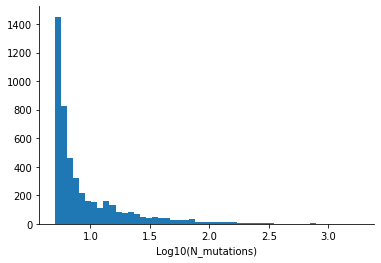

In [17]:
fig=plt.figure()
ax=fig.gca()
ax.hist(np.log10(first_order.n_mutations), bins=50)
ax.set_xlabel("Log10(N_mutations)")

sns.despine()


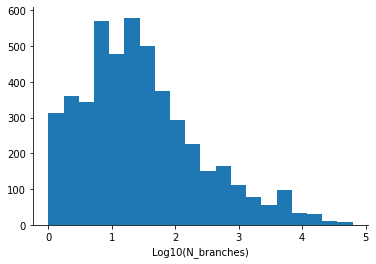

In [18]:
fig=plt.figure()
ax=fig.gca()
first_order["log_n_branches"] = [np.log10(x) if x > 0 else 0 for x in first_order.n_branches_with]
ax.hist(first_order.log_n_branches, bins=20)
ax.set_xlabel("Log10(N_branches)")

sns.despine()


In [19]:
# Add the first order statistics to the pairwise df
merged = pairwise.merge(first_order, left_on="position_i", right_on = "pos", how="left")
merged = merged.merge(first_order, left_on = "position_j", right_on = "pos", how="left", suffixes=["_i", "_j"])

# Select only needed columns and save
merged = merged[['position_i', 'mat_index_i', 'position_j','mat_index_j', 
                 'n_mutations_i', 'n_mutations_j','n_reversions_i',
                 'n_reversions_j','n_branches_with_i','n_branches_with_j',
                 'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i', 'n_muts_same_branch',
                 'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j']]

merged.to_csv("01.mutation_and_comutation_data/combined_position.csv")

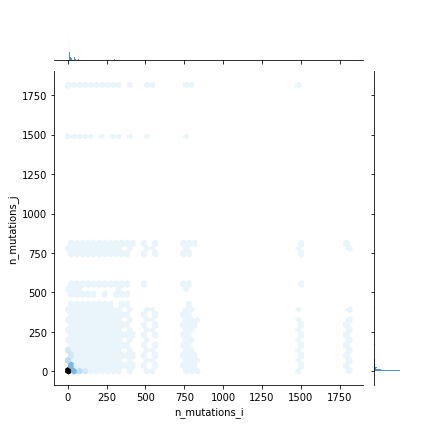

In [20]:
p = merged.query("n_mutations_i >4 and n_mutations_j > 4")
len(p)
sns.jointplot(data=p, x="n_mutations_i", y="n_mutations_j", kind="hex", bins=20)
